In [47]:

import json
import numpy as np
import matplotlib.pyplot as plt

import led_config_utils as utils
from impossible_dialogue import led_config

from importlib import reload
reload(utils)
reload(led_config)

<module 'impossible_dialogue.led_config' from '/Users/pitzer/Documents/workspace/impossible_dialogue/impossible_dialogue/led_config.py'>

Processing face_front
Number of paths: 3
Processing path 0
Path points: 26, Polygon path points: 3
Segment face_0: length=0m, num_leds=26
Processing path 1
Path points: 26, Polygon path points: 3
Segment face_1: length=0m, num_leds=26
Processing path 2
Path points: 302, Polygon path points: 10
Segment face_2: length=0m, num_leds=302


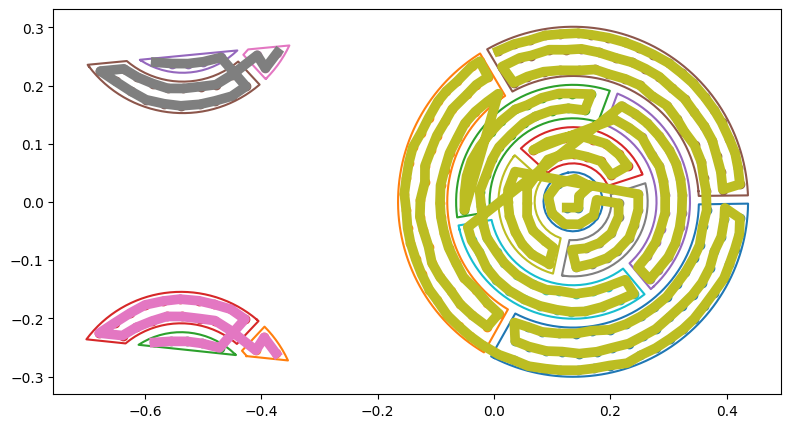

Processing face_front_right
Polygon does not have enough vertices: [array([-0.3944787 ,  1.30874645,  0.28251986]), array([-0.39434916,  1.30942633,  0.28250448])]
Number of paths: 1
Processing path 0
Path points: 100, Polygon path points: 5
Segment face_100: length=0m, num_leds=100


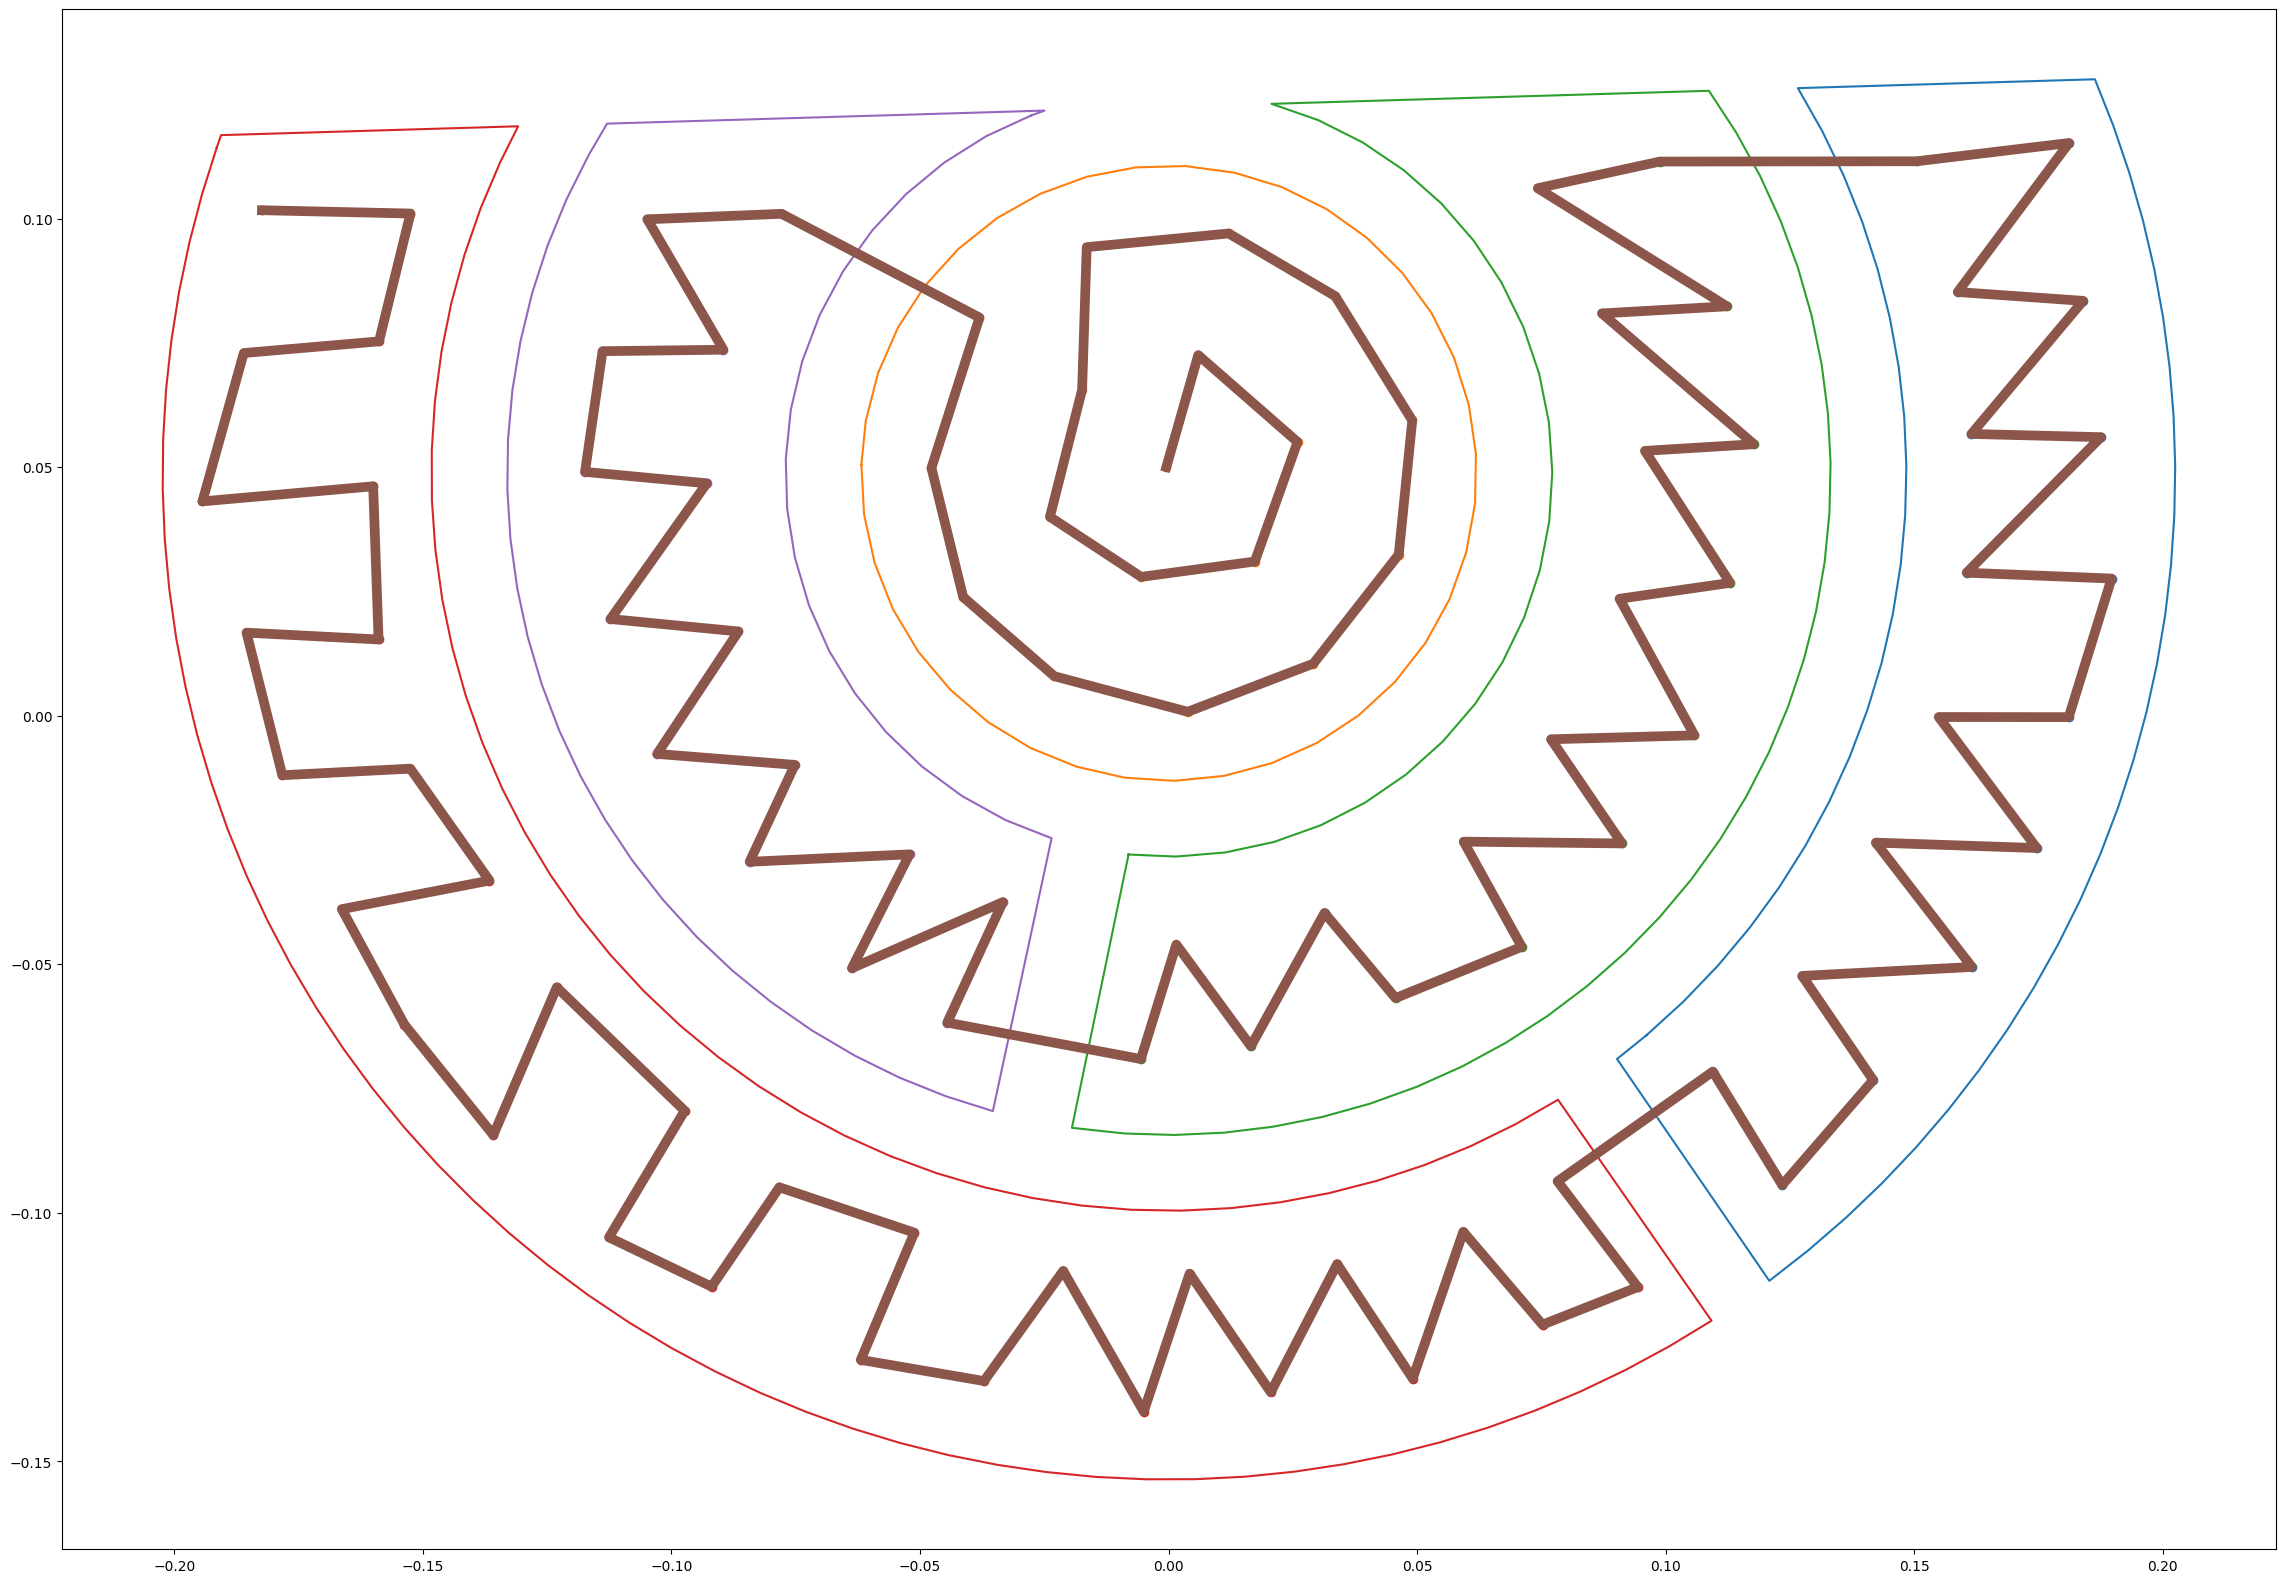

Processing face_front_left
Number of paths: 1
Processing path 0
Path points: 100, Polygon path points: 5
Segment face_200: length=0m, num_leds=100


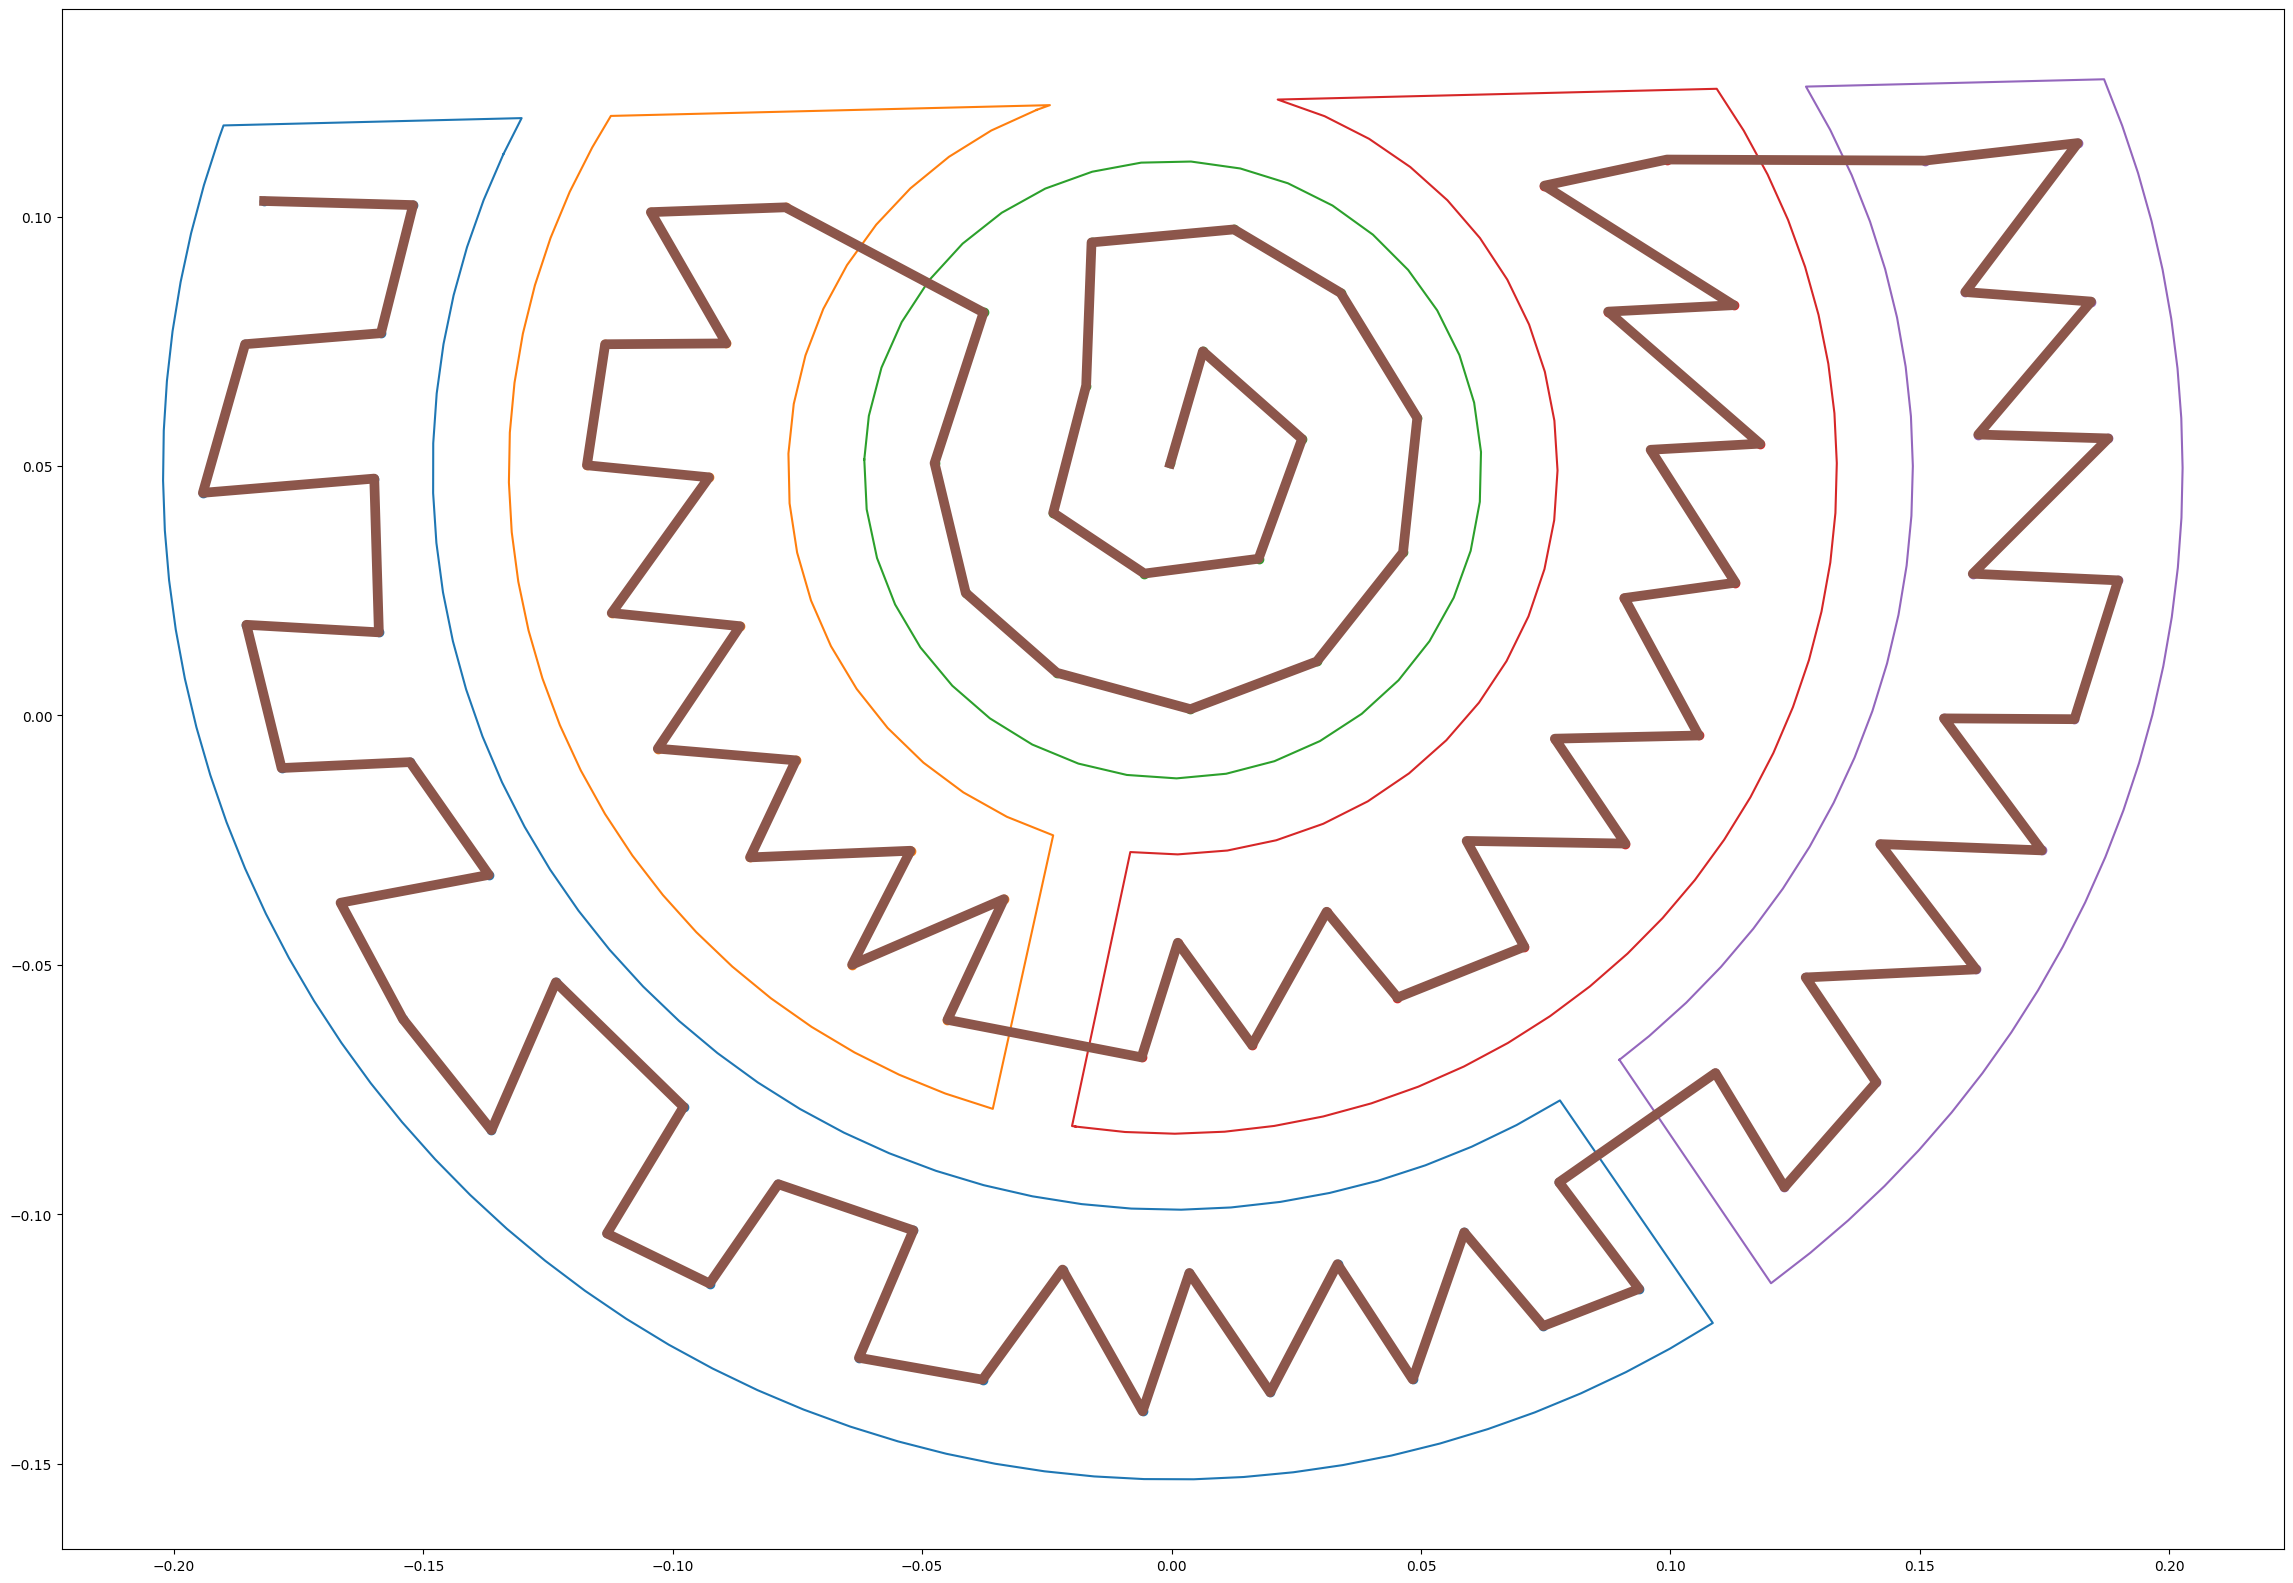

In [48]:
all_segments = {}
all_polygons = []
design = "design2"
for face_index, face in enumerate(['face_front', 'face_right', 'face_left']):
    print(f'Processing {face}')
    fig = plt.figure(face_index)
    polygon_segments = utils.read_line_segments(f'../config/{design}/{face}_polygon_line_segments.csv')
    polygons = utils.create_polygons(polygon_segments)
    polygons_2d, U, mu = utils.project_polygons_2d(polygons)
    utils.plot_polygons_2d(polygons_2d)
    polygon_index_offset = len(all_polygons)
    all_polygons.extend(polygons)

    path_segments = utils.read_line_segments(f'../config/{design}/{face}_led_line_segments.csv')
    paths = utils.create_paths(path_segments)
    print(f"Number of paths: {len(paths)}")
    for path_index, path in enumerate(paths): 
        print(f"Processing path {path_index}")
        path_2d = utils.project_path_2d(path, U, mu)
        utils.plot_path_2d(path_2d)
        polygon_indices = utils.find_polygon_indices(path_2d, polygons_2d, polygon_index_offset)
        polygon_path, num_points_in_polygons = utils.create_polygon_path(
            polygon_indices, all_polygons)
        polygon_path_2d = utils.project_path_2d(polygon_path, U, mu)
        # utils.plot_path_2d(polygon_path_2d)

        if len(path.vertices) == 0:
            print('No points available.')
            continue

        print(f"Path points: {len(path.vertices)}, Polygon path points: {len(polygon_path.vertices)}")
        # print(f"Polygon indices: {polygon_indices}")
        uid = face_index * 100 + path_index
        name = f"face_{uid}"
        segment = led_config.Segment(uid=uid, name=name, 
                                     points=np.array(path.vertices),
                                     num_leds=len(path.vertices), length=0,
                                     polygon_indices=np.array(polygon_indices),
                                     polygon_centers=np.array(polygon_path.vertices),
                                     num_points_in_polygons=np.array(num_points_in_polygons),
                                     points_2d=np.array(path_2d.vertices))
        print(f'Segment {segment.name}: length={segment.length}m, num_leds={segment.num_leds}')
        all_segments[name] = segment
    
    plt.axis('scaled')
    plt.show()
    plt.rcParams['figure.figsize'] = [100, 20]

Segment: front_eyes, num_points: 52


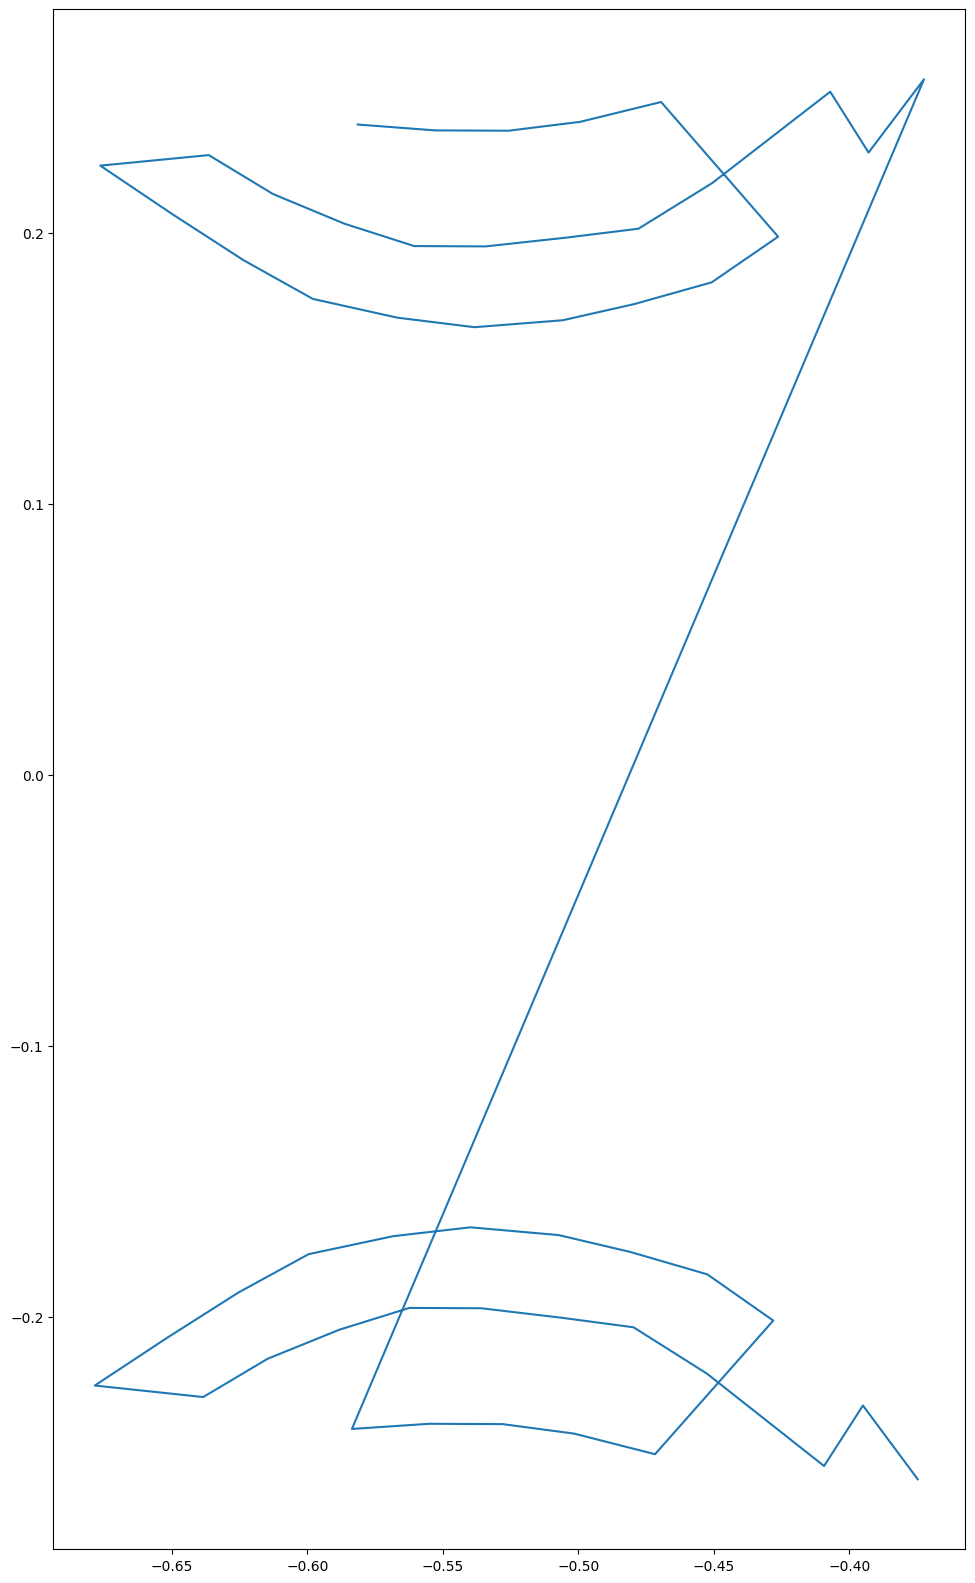

Segment: front_mouth, num_points: 302


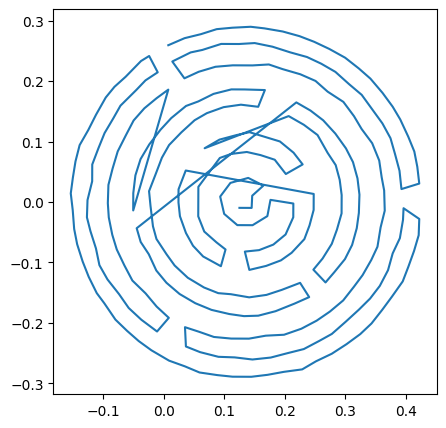

Segment: front_right_eyes, num_points: 100


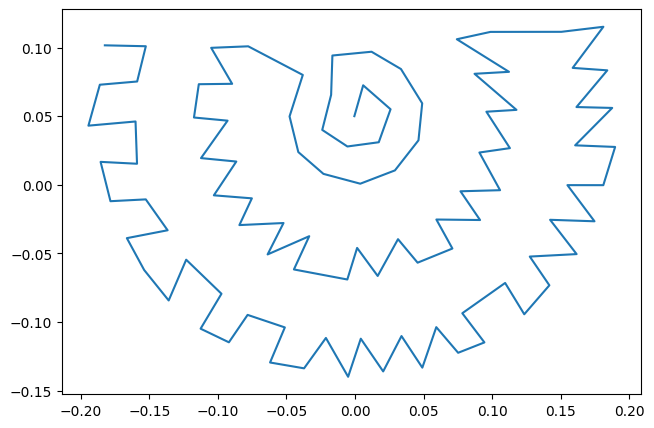

Segment: front_left_eyes, num_points: 100


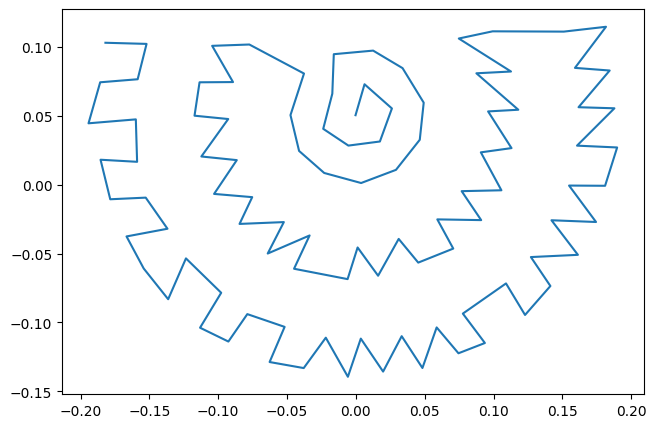

In [49]:
merge_config = {
    "design1": [
        ("front_nose_eyes", [("face_4", True), ("face_0", True), ("face_1", False), ("face_5", False)]),
        ("front_mouth", [("face_2", False), ("face_3", True)]),
        ("front_right_eyes", [("face_102", False), ("face_101", False)]),
        ("front_right_mouth", [("face_100", False)]),
        ("front_left_eyes", [("face_202", False), ("face_201", False)]),
        ("front_left_mouth", [("face_200", False)]),
    ],
    "design2": [
        ("front_mouth", [
            ("face_2", False), 
        ]),
        ("front_eyes", [("face_0", False), ("face_1", False)]),
        ("front_right_eyes", [("face_100", False)]),
        ("front_left_eyes", [("face_200", False)]),
    ]
}

# for merge_list in [SEGMENT_1, SEGMENT_2, SEGMENT_3, SEGMENT_4, SEGMENT_5, SEGMENT_6]:
for merged_name, merge_list in merge_config[design]:
    name1, flip1 = merge_list[0]
    segment1 = all_segments[name1]
    if flip1:
        segment1.flip()
    for name2, flip2 in merge_list[1:]:
        segment2 = all_segments.pop(name2)
        if flip2:
            segment2.flip()
        segment1.merge(segment2)
    segment1.name = merged_name

for segment in all_segments.values():
    print(f"Segment: {segment.name}, num_points: {len(segment.points)}")
    utils.plot_segment(segment)

In [50]:
# Create LED config
config = led_config.LedConfig()
config.polygons = all_polygons
for segment in all_segments.values():
    config.led_segments.append(segment)
    config.total_num_segments += 1
    config.total_length += segment.length
    config.total_num_leds += segment.num_leds

with open(f'../config/{design}/led_config.json', 'w', encoding='utf-8') as f:
    json.dump(config.to_dict(), f, ensure_ascii=False, indent=4)